## **Notebook Description**

This notebook: 
1. Trains the model on the training data.
2. Test against the test data.

## **Import Libraries**

In [1]:
import os
import torch
import pandas as pd
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
import torch.nn.functional as F
from math import sqrt
import matplotlib.pyplot as plt

## **Set Folder Paths**

In [2]:
# Set folder path for pytorch data objects
folder_path = r'data\torch_data_object_training'

In [3]:
# Path to the CSV containing labeled nodes info
labels_info_path = r'data\torch_data_object_training\labels_info.csv' 

In [4]:
model_path = r'data\1_pytorch_model\model.pth' 

## **Functions**

Define a function to load all graph data objects from a folder. Each graph is assumed to be saved as a separate file.

In [5]:
# Function to load all graph data objects from a folder
def load_graph_data_objects(folder_path, start_run=None, end_run=None):
    graph_data_objects = []
    for file_name in sorted(os.listdir(folder_path)):
        if file_name.endswith('.pt'):
            run_number = int(file_name.split('_')[1].split('.')[0])  # Assumes filename format is "run_X.pt"
            if start_run is not None and run_number < start_run:
                continue
            if end_run is not None and run_number > end_run:
                break
            graph_path = os.path.join(folder_path, file_name)
            graph_data = torch.load(graph_path)
            if isinstance(graph_data, Data):
                graph_data_objects.append(graph_data)
    return graph_data_objects

In [6]:
# Function to load or initialize the model
def load_or_initialize_model(model_path, model_class, *model_args, **model_kwargs):
    if os.path.exists(model_path):
        model = model_class(*model_args, **model_kwargs)
        model.load_state_dict(torch.load(model_path))
        print("Loaded previously trained model.")
    else:
        model = model_class(*model_args, **model_kwargs)
        print("Initialized new model.")
    return model

In [7]:
# Function to load the number of labeled nodes for each dataset from a CSV
def load_num_labeled_nodes(labels_info_path):
    labels_info = pd.read_csv(labels_info_path)
    return labels_info['num_labeled_nodes'].tolist()

In [8]:
# Function to Count Graph Data Objects in a Folder
def count_graph_data_objects(folder_path):
    count = 0
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.pt'):  # Assuming saved PyTorch tensor files
            count += 1
    return count

In [9]:
def train(model, optimizer, data, mask):
    model.train()
    optimizer.zero_grad()
    
    out = model(data)  # Model outputs for all nodes
    out = out.squeeze()
    
    # Mask to identify non-placeholder labels
    # Adjust this condition based on your placeholder_value and task
    valid_label_mask = data.y != placeholder_value
    
    # Apply both the extended mask and valid_label_mask to filter predictions and labels
    valid_out = out[mask & valid_label_mask]
    valid_labels = data.y[mask & valid_label_mask]
    
    loss = F.mse_loss(valid_out, valid_labels)  # Calculate loss on non-placeholder, valid data points only
    
    loss.backward()
    optimizer.step()
    
    return loss.item()

In [10]:
def test(model, data, mask):
    model.eval()
    with torch.no_grad():
        out = model(data)
        out = out.squeeze()  # Ensure the output matches expected dimensions

        # Ensure the mask is for the full set of nodes, adjusting if it was originally for labeled nodes only
        if mask.size(0) != out.size(0):
            # This assumes the original mask size corresponds to the number of labeled nodes
            # and needs to be extended to match the full set of nodes (similar to what was done for training)
            extended_mask = torch.cat((mask, torch.zeros(data.num_nodes - mask.size(0), dtype=torch.bool, device=mask.device)))
        else:
            extended_mask = mask

        # Apply the extended mask to filter predictions and labels for loss calculation
        valid_out = out[extended_mask]
        valid_labels = data.y[extended_mask]
        
        test_loss = F.mse_loss(valid_out, valid_labels).item()

    return test_loss


## **Classes**

#### **Define the GNN Model**

This section sets up a class that specifies a 2 layer GCN model and a method for how data flows through the model (forward pass).

In [11]:
class SimpleGCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes):
        '''
        Initialises a model that processes graph-structured data using 
        simple two-layer GCN architecture.
        
        Args:
        num_node_features = number of features each node in the input graph has
        num_classes = number of output classes
        '''
        super(SimpleGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, 16)  # First GCN layer
        self.conv2 = GCNConv(16, num_classes)        # Second GCN layer

    def forward(self, data):
        '''
        Defines the forward pass of the model

        Args:
        data = object containing graph data
        '''
        x, edge_index = data.x, data.edge_index    # Extract node features and graph structure
        x = self.conv1(x, edge_index)    # Apply the first GCN convolution layer
        x = F.relu(x)  # Apply the ReLU activation function to the input tensor x
        x = F.dropout(x, training=self.training) # Apply dropout regularisation to reduce overfitting during training
        x = self.conv2(x, edge_index) # Apply the second GCN convolution layer
        
        return x  # model's predictions for each node 

## **Load Model & Objects**

In [12]:
# Load graph data objects

start_run, end_run = 1, 3    # SPECIFY THE RANGE OF PT HERE
graph_data_objects = load_graph_data_objects(folder_path, start_run=start_run, end_run=end_run)

print(f'Loaded {len(graph_data_objects)} graph data objects.')

Loaded 3 graph data objects.


In [13]:
# Count graph data objects directly from the folder 

num_graphs = count_graph_data_objects(folder_path)
print(f'Total number of graph data objects in the folder: {num_graphs}')

# Load the number of labeled nodes for each graph
num_labeled_nodes_list = load_num_labeled_nodes(labels_info_path)  

Total number of graph data objects in the folder: 3


## **Model Settings and Optimiser**

This section creates the model settings, calls the model function and sets the optimiser.

In [14]:
# Model Settings
num_node_features = graph_data_objects[0].num_node_features  #  Retrieves the number of features associated with the nodes
num_classes = 1  # Set the number of output classes (no changes needed)

# Adjust the criterion according to your task
criterion = torch.nn.MSELoss()  

## **Training Loop**

This section defines the training and test function and returns the MSE loss.

In [15]:
model = load_or_initialize_model(model_path, SimpleGCN, num_node_features, num_classes)

# Using Adam optimizer, lr = learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Initialized new model.


In [16]:
# Check if GPU is avaliable 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

SimpleGCN(
  (conv1): GCNConv(4, 16)
  (conv2): GCNConv(16, 1)
)

In [17]:
train_losses = []
test_losses = []

for idx, data in enumerate(graph_data_objects):
    data = data.to(device)  # Move data to the appropriate device
    
    num_labeled_nodes = num_labeled_nodes_list[idx]  # Retrieve the number of labeled nodes for the current graph
    num_total_nodes = data.num_nodes  # Total number of nodes in the current graph

    # Placeholder value for unlabeled nodes - choose based on your task
    placeholder_value = 0

    # Extend data.y with the placeholder value for unlabeled nodes
    if data.y.size(0) < num_total_nodes:
        # Calculate the number of unlabeled nodes
        num_unlabeled_nodes = num_total_nodes - data.y.size(0)
        
        # Create a tensor of placeholders for unlabeled nodes
        placeholders = torch.full((num_unlabeled_nodes,), placeholder_value, dtype=data.y.dtype)
        
        # Extend data.y
        data.y = torch.cat((data.y, placeholders))

    # Generate initial masks for labeled nodes only
    train_mask = torch.zeros(num_labeled_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_labeled_nodes, dtype=torch.bool)

    # Randomly permute indices of labeled nodes to split into training and testing
    indices = torch.randperm(num_labeled_nodes)
    num_train = int(num_labeled_nodes * 0.8)  # Split, e.g., 80% for training

    # Set training and testing masks for labeled nodes
    train_mask[indices[:num_train]] = True
    test_mask[indices[num_train:]] = True

    # Extend masks to cover all nodes
    # Note: For training, include unlabeled nodes; for testing, focus only on labeled nodes
    extended_train_mask = torch.cat((train_mask, torch.ones(num_total_nodes - num_labeled_nodes, dtype=torch.bool)))
    extended_test_mask = torch.cat((test_mask, torch.zeros(num_total_nodes - num_labeled_nodes, dtype=torch.bool)))

    # Training and testing loop
    for epoch in range(100):  # Adjust the number of epochs as needed
        train_loss = train(model, optimizer, data, extended_train_mask)  # Assuming extended masks are used
        test_loss = test(model, data, extended_test_mask)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        print(f'Graph {idx+1}, Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Graph 1, Epoch 1: Train Loss: 342909.5312, Test Loss: 152875.8125
Graph 1, Epoch 2: Train Loss: 279092.3750, Test Loss: 127306.6875
Graph 1, Epoch 3: Train Loss: 262352.7188, Test Loss: 108245.7344
Graph 1, Epoch 4: Train Loss: 260686.2344, Test Loss: 95408.7734
Graph 1, Epoch 5: Train Loss: 246656.6406, Test Loss: 87367.9766
Graph 1, Epoch 6: Train Loss: 211200.0312, Test Loss: 82152.3750
Graph 1, Epoch 7: Train Loss: 220685.6562, Test Loss: 78977.0469
Graph 1, Epoch 8: Train Loss: 207501.3125, Test Loss: 77169.5312
Graph 1, Epoch 9: Train Loss: 211616.1406, Test Loss: 76233.4844
Graph 1, Epoch 10: Train Loss: 173496.6875, Test Loss: 75846.1484
Graph 1, Epoch 11: Train Loss: 173167.0625, Test Loss: 75723.8828
Graph 1, Epoch 12: Train Loss: 163304.8750, Test Loss: 75670.0234
Graph 1, Epoch 13: Train Loss: 174018.7969, Test Loss: 75667.1719
Graph 1, Epoch 14: Train Loss: 162948.8906, Test Loss: 75743.5625
Graph 1, Epoch 15: Train Loss: 147383.4688, Test Loss: 75914.9922
Graph 1, Epoch 1

## **Training and Test Set**

The section below prepares data for training and testing in a graph-based context where some nodes are labeled and others are not. The purpose of the mask is to identify and only include the labeled nodes in training and testing.

1. Split the labeled nodes into training and test sets
2. Creates masks to identify which nodes belong to each set.

## **Execute the Training Loop, Calculate Loss**

This section executes the training loop.

## **Evaluate the Model**

Test the trained model onto the test dataset.

In [18]:
# Assuming you have the necessary variables defined
test_loss = test(model, data, test_mask)
print(f'Test Loss: {test_loss:.2f}')

Test Loss: 87113.27


## **Visualise the Loss Function**

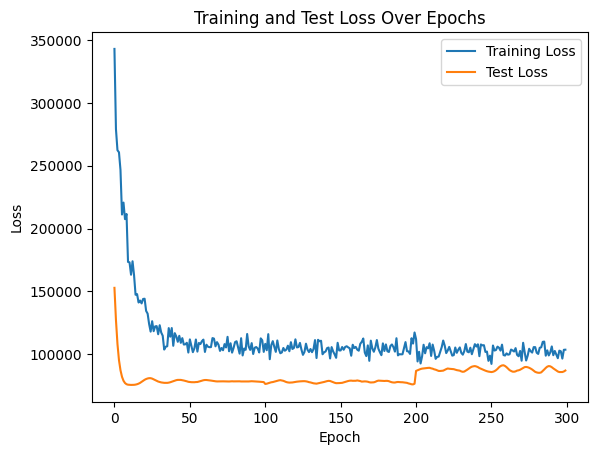

In [19]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Over Epochs')
plt.legend()
plt.show()


## **Save the Model**

In [20]:
# Define the file path variable using an f-string if you need dynamic components
file_path = rf'data\1_pytorch_model\model.pth'  

# Save the model
torch.save(model.state_dict(), file_path)